In [1]:
import jax
from jax.config import config; config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import sys; sys.path.insert(1, '..')

import dill as pickle

from algs.train import IRL_Trainer, TracePlotter
from env.utils import ExampleMDPs
from env.sample import Sampler
from algs.irl import irlL1Proj
from algs.irl import initStateOnlyIRL, stochNaturalIRL

import jax.numpy as jnp

### Example training with oracle access to the gradients

In [3]:
mdp = ExampleMDPs.gworld1()
trainer = IRL_Trainer(mdp,policy_lr=2,reward_lr=2e-1,beta=0.1)
trainData = trainer.train(300)
pickle.dump(trainData, open( "../logs/example_exact_irl.pkl", "wb" ) )

Computing the expert's policy


100%|██████████| 300/300 [00:08<00:00, 36.98it/s]


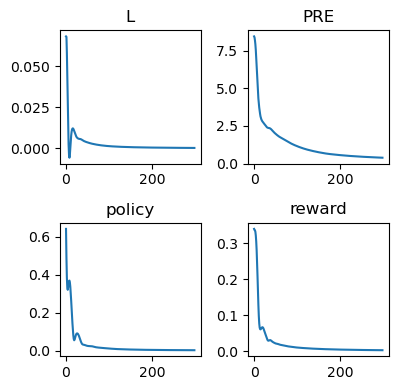

In [4]:
trainData = pickle.load( open( "../logs/example_exact_irl.pkl", "rb" ) )
scalar_plots = [['L','PRE'],['policy','reward']]
_ = TracePlotter.scalarPlotArray(scalar_plots,
                                 trainData.trainer,
                                 trainData.optimizer,
                                 trainData.trace,(4,4))

### Example training with state-only-rewards

In [5]:
m = mdp.m
state_only = lambda w : jnp.repeat(w,mdp.m,1)
mdp = ExampleMDPs.gworld1()
w_ref = jnp.expand_dims(
    jnp.array([1 if s==2 else 0 for  s in range(9)]),1)
mdp.R = state_only(w_ref)
trainer = IRL_Trainer(mdp,policy_lr=2,reward_lr=2e-1,beta=0.1,rFun=state_only,init_params=initStateOnlyIRL)
trainData = trainer.train(60)
pickle.dump(trainData, open( "../logs/example_so_exact_irl.pkl", "wb" ) )

Computing the expert's policy


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:05<00:00, 11.50it/s]


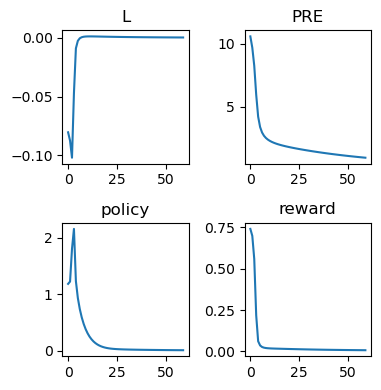

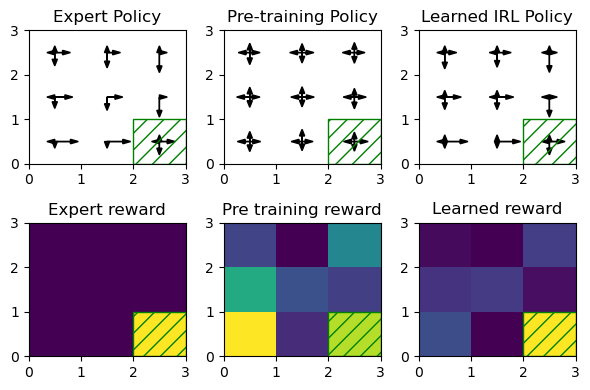

In [6]:
trainData = pickle.load( open( "../logs/example_so_exact_irl.pkl", "rb" ) )
scalar_plots = [['L','PRE'],['policy','reward']]
_ = TracePlotter.scalarPlotArray(scalar_plots,
                                 trainData.trainer,
                                 trainData.optimizer,
                                 trainData.trace,(4,4))
_ = TracePlotter.gworldIRLPlot(trainData.trainer,
                               trainData.optimizer,
                               trainData.trace,fsize=(6,4))

### Example training with stochastic gradient estimators

In [7]:
mdp.m
state_only = lambda w : jnp.repeat(w,mdp.m,1)
mdp = ExampleMDPs.gworld1()
w_ref = jnp.expand_dims(jnp.array([1 if s==2 else 0 for  s in range(9)]),1)
mdp.R = state_only(w_ref)
smp = Sampler(mdp,batchsize=1000,horizon=250)
trainer = IRL_Trainer(mdp,policy_lr=1e-1,reward_lr=5e-2,beta=0.1,
                      init_params=initStateOnlyIRL,
                      sampler=smp,
                      rFun=state_only,
                      gradients=stochNaturalIRL,
                      max_theta=80,
                      proj=irlL1Proj,
                      key = jax.random.PRNGKey(1312))
trainData = trainer.train(100)
pickle.dump(trainData, open( "../logs/example_stoch_so_irl.pkl", "wb" ) )

Computing the expert's policy


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:07<00:00,  3.07s/it]


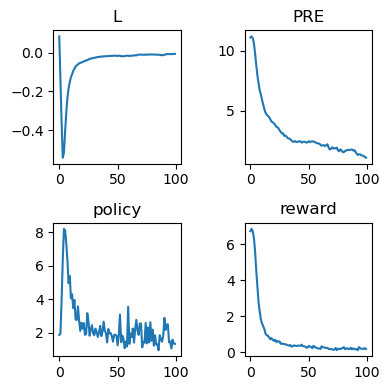

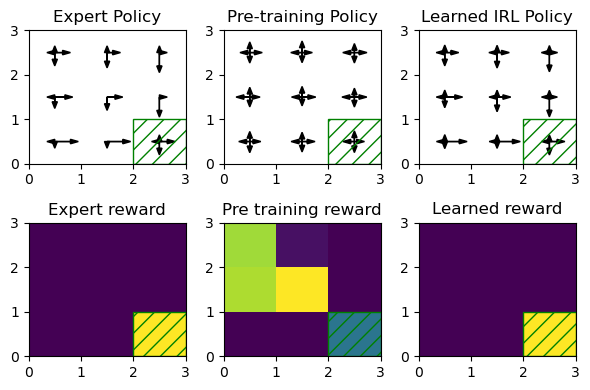

In [9]:
trainData = pickle.load( open( "../logs/example_stoch_so_irl.pkl", "rb" ) )
scalar_plots = [['L','PRE'],['policy','reward']]
_ = TracePlotter.scalarPlotArray(scalar_plots,
                                 trainData.trainer,
                                 trainData.optimizer,
                                 trainData.trace,(4,4))
_ = TracePlotter.gworldIRLPlot(trainData.trainer,
                               trainData.optimizer,
                               trainData.trace,fsize=(6,4))